In [ ]:
! pip install kaggle

In [2]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download gpiosenka/cards-image-datasetclassification

Dataset URL: https://www.kaggle.com/datasets/gpiosenka/cards-image-datasetclassification
License(s): CC0-1.0
 79% 304M/385M [00:02<00:00, 101MB/s] 
100% 385M/385M [00:02<00:00, 144MB/s]


In [15]:
!unzip cards-image-datasetclassification.zip -d cards-image-datasetclassification

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: cards-image-datasetclassification/train/jack of spades/059.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/060.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/061.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/062.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/063.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/064.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/065.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/066.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/067.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/068.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/069.jpg  
  inflating: cards-image-datasetclassification/train/jack of spades/070.jp

In [3]:
! pip install torchinfo

In [4]:
import os
import time
import copy
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models, datasets
from torchinfo import summary

from sklearn.metrics import (
    confusion_matrix, classification_report, f1_score,
    accuracy_score, precision_recall_fscore_support
)
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder


In [5]:
torch.cuda.is_available()

True

In [23]:
class CardsDataset(Dataset):
    def __init__(self, df, head_path, transform=None):

        df = df[~df['filepaths'].astype(str).str.contains('output', na=False)]
        df = df.reset_index(drop=True)
        self.df = df
        self.transform = transform
        self.head_path = head_path


        self.label_encoder = LabelEncoder()
        self.df['label_code'] = self.label_encoder.fit_transform(self.df['card type'])


        self.classes = self.label_encoder.classes_
        self.num_classes = len(self.classes)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = f"{self.head_path}/{self.df.loc[idx, 'filepaths']}"
        label = self.df.iloc[idx]['label_code']

        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

In [7]:
def get_transforms(image_size=224):
    train_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    val_test_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                           std=[0.229, 0.224, 0.225])
    ])

    return train_transform, val_test_transform

In [8]:
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [9]:
def create_dataloaders(csv_path, head_path, batch_size=32, train_transform=None, val_test_transform=None):

    df = pd.read_csv(csv_path)

    train_df = df[df['data set'] == 'train']
    val_df = df[df['data set'] == 'valid']
    test_df = df[df['data set'] == 'test']

    train_dataset = CardsDataset(train_df, head_path, transform=train_transform)
    val_dataset = CardsDataset(val_df, head_path, transform=val_test_transform)
    test_dataset = CardsDataset(test_df, head_path, transform=val_test_transform)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    print(f"Обучающих примеров: {len(train_dataset)}")
    print(f"Валидационных примеров: {len(val_dataset)}")
    print(f"Тестовых примеров: {len(test_dataset)}")
    print(f"Классов: {train_dataset.num_classes}")

    return train_loader, val_loader, test_loader, train_dataset.classes

In [10]:
def create_model(num_classes, freeze_layers=True, use_pretrained=True):

    if use_pretrained:
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
    else:
        model = models.efficientnet_b0(weights=None)

    if freeze_layers:
        for param in model.parameters():
            param.requires_grad = False

    num_ftrs = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(num_ftrs, num_classes)
    )

    if freeze_layers:
        for param in model.features[-5:].parameters():
          param.requires_grad = True
        for param in model.classifier.parameters():
            param.requires_grad = True

    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)

    return model.to(device)

In [11]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler=None):

    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    progress_bar = tqdm(dataloader, desc='Training')
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        total_samples += inputs.size(0)

        progress_bar.set_postfix({
            'loss': running_loss / total_samples,
            'acc': (running_corrects.float() / total_samples).item()
        })

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.float() / total_samples

    if scheduler:
        scheduler.step(epoch_loss)

    return epoch_loss, epoch_acc.item()

def validate_epoch(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc='Validation')
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            total_samples += inputs.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({
                'loss': running_loss / total_samples,
                'acc': (running_corrects.float() / total_samples).item()
            })

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects.float() / total_samples

    return epoch_loss, epoch_acc.item(), all_preds, all_labels

In [12]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                scheduler, num_epochs=25, patience=5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 0

    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    epochs_no_improve = 0

    for epoch in range(num_epochs):
        print(f"\n{'='*50}")
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"{'='*50}")

        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, scheduler
        )

        val_loss, val_acc, _, _ = validate_epoch(model, val_loader, criterion)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        scheduler.step(metrics=val_loss)

        print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_acc': val_acc,
            }, 'best_model.pth')
            print(f"Saved best model with validation accuracy: {val_acc:.4f}")
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch+1} epochs")
            break

    print(f"\nTraining completed. Best validation accuracy: {best_acc:.4f} at epoch {best_epoch+1}")

    model.load_state_dict(best_model_wts)

    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'val_losses': val_losses,
        'val_accs': val_accs
    }

In [13]:
def evaluate_model(model, test_loader, class_names):

    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted'
    )

    print(f"\n{'='*50}")
    print("TEST SET RESULTS")
    print(f"{'='*50}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")


    print(f"\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)

    return {
        'predictions': all_preds,
        'labels': all_labels,
        'probabilities': all_probs,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

In [14]:
def plot_training_history(history):

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))


    axes[0].plot(history['train_losses'], label='Train Loss')
    axes[0].plot(history['val_losses'], label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training and Validation Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)


    axes[1].plot(history['train_accs'], label='Train Accuracy')
    axes[1].plot(history['val_accs'], label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
    plt.show()


def visualize_predictions(probs, test_loader, class_names, num_images=9, save_path='predictions.png'):

    model.eval()

    preds = np.argmax(probs, axis=1)
    images = []
    labels = []
    with torch.no_grad():
        for _inputs, _labels in tqdm(test_loader, desc='Testing'):
            cur_images, cur_labels = _inputs.cpu().numpy(), _labels.cpu().numpy()
            images.extend(cur_images)
            labels.extend(cur_labels)

    images = np.array(images)


    mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    images = images * std + mean
    images = np.clip(images, 0, 1)


    rows = int(np.ceil(np.sqrt(num_images)))
    cols = int(np.ceil(num_images / rows))
    fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
    axes = axes.ravel()

    rng = np.random.default_rng()
    rand_idx = rng.choice(len(images), size=min(num_images, len(images)), replace=False)

    for i, idx in enumerate(rand_idx):
        ax = axes[i]
        ax.imshow(np.moveaxis(images[idx], 0, -1))

        true_label = class_names[labels[idx]]
        pred_label = class_names[preds[idx]]
        confidence = probs[idx][preds[idx]]

        color = 'green' if true_label == pred_label else 'red'

        ax.set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}",
                    color=color, fontsize=10)
        ax.axis('off')

    plt.suptitle('Model Predictions on Test Images', fontsize=14)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

In [17]:
config = {
    'csv_path': '/content/cards-image-datasetclassification/cards.csv',
    'head_path': "/content/cards-image-datasetclassification",
    'batch_size': 256,
    'num_epochs': 20,
    'learning_rate': 0.001,
    'freeze_layers': True,
    'patience': 5,
    'img_size': 224
}

In [25]:

train_transform, val_test_transform = get_transforms()
train_loader, val_loader, test_loader, class_names = create_dataloaders(
    config['csv_path'], config['head_path'],
    batch_size=config['batch_size'],
    train_transform=train_transform, val_test_transform=val_test_transform
)

Обучающих примеров: 7624
Валидационных примеров: 265
Тестовых примеров: 265
Классов: 14


In [26]:

model = create_model(
    num_classes=len(class_names),
    freeze_layers=config['freeze_layers'],
    use_pretrained=True
)

summary(model, input_size=(config['batch_size'], 3, config['img_size'], config['img_size']))

Layer (type:depth-idx)                                  Output Shape              Param #
EfficientNet                                            [256, 14]                 --
├─Sequential: 1-1                                       [256, 1280, 7, 7]         --
│    └─Conv2dNormActivation: 2-1                        [256, 32, 112, 112]       --
│    │    └─Conv2d: 3-1                                 [256, 32, 112, 112]       (864)
│    │    └─BatchNorm2d: 3-2                            [256, 32, 112, 112]       (64)
│    │    └─SiLU: 3-3                                   [256, 32, 112, 112]       --
│    └─Sequential: 2-2                                  [256, 16, 112, 112]       --
│    │    └─MBConv: 3-4                                 [256, 16, 112, 112]       (1,448)
│    └─Sequential: 2-3                                  [256, 24, 56, 56]         --
│    │    └─MBConv: 3-5                                 [256, 24, 56, 56]         (6,004)
│    │    └─MBConv: 3-6                      

In [20]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=config['learning_rate']
)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5
)

In [28]:
model, history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=config['num_epochs'],
    patience=config['patience']
)



Epoch 1/20


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.61it/s, loss=0.396, acc=0.868]


Train Loss: 1.4206, Train Acc: 0.5302
Val Loss: 0.3957, Val Acc: 0.8679
Saved best model with validation accuracy: 0.8679

Epoch 2/20


Validation: 100%|██████████| 2/2 [00:00<00:00,  2.03it/s, loss=0.14, acc=0.951]


Train Loss: 0.4201, Train Acc: 0.8642
Val Loss: 0.1397, Val Acc: 0.9509
Saved best model with validation accuracy: 0.9509

Epoch 3/20


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s, loss=0.0732, acc=0.974]


Train Loss: 0.2225, Train Acc: 0.9263
Val Loss: 0.0732, Val Acc: 0.9736
Saved best model with validation accuracy: 0.9736

Epoch 4/20


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.87it/s, loss=0.0888, acc=0.977]


Train Loss: 0.1482, Train Acc: 0.9511
Val Loss: 0.0888, Val Acc: 0.9774
Saved best model with validation accuracy: 0.9774

Epoch 5/20


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.94it/s, loss=0.134, acc=0.97]


Train Loss: 0.1206, Train Acc: 0.9616
Val Loss: 0.1339, Val Acc: 0.9698

Epoch 6/20


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.52it/s, loss=0.101, acc=0.981]


Train Loss: 0.0981, Train Acc: 0.9690
Val Loss: 0.1007, Val Acc: 0.9811
Saved best model with validation accuracy: 0.9811

Epoch 7/20


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s, loss=0.0773, acc=0.981]


Train Loss: 0.0634, Train Acc: 0.9788
Val Loss: 0.0773, Val Acc: 0.9811

Epoch 8/20


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s, loss=0.065, acc=0.985]


Train Loss: 0.0455, Train Acc: 0.9865
Val Loss: 0.0650, Val Acc: 0.9849
Saved best model with validation accuracy: 0.9849

Epoch 9/20


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.93it/s, loss=0.0663, acc=0.985]


Train Loss: 0.0376, Train Acc: 0.9885
Val Loss: 0.0663, Val Acc: 0.9849

Epoch 10/20


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.91it/s, loss=0.0616, acc=0.981]


Train Loss: 0.0335, Train Acc: 0.9907
Val Loss: 0.0616, Val Acc: 0.9811

Epoch 11/20


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s, loss=0.063, acc=0.985]


Train Loss: 0.0281, Train Acc: 0.9919
Val Loss: 0.0630, Val Acc: 0.9849

Epoch 12/20


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.92it/s, loss=0.063, acc=0.985]


Train Loss: 0.0236, Train Acc: 0.9933
Val Loss: 0.0630, Val Acc: 0.9849

Epoch 13/20


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.98it/s, loss=0.0622, acc=0.981]

Train Loss: 0.0251, Train Acc: 0.9930
Val Loss: 0.0622, Val Acc: 0.9811

Early stopping triggered after 13 epochs

Training completed. Best validation accuracy: 0.9849 at epoch 8


In [29]:
test_results = evaluate_model(model, val_loader, class_names)


Testing: 100%|██████████| 2/2 [00:01<00:00,  1.89it/s]


TEST SET RESULTS
Accuracy: 0.9849
Precision: 0.9856
Recall: 0.9849
F1-Score: 0.9848

Classification Report:
              precision    recall  f1-score   support

         ace       1.00      0.95      0.97        20
       eight       1.00      1.00      1.00        20
        five       0.95      1.00      0.98        20
        four       1.00      1.00      1.00        20
        jack       0.95      1.00      0.98        20
        king       0.95      1.00      0.98        20
        nine       1.00      1.00      1.00        20
       queen       1.00      0.95      0.97        20
       seven       1.00      1.00      1.00        20
         six       1.00      1.00      1.00        20
         ten       1.00      1.00      1.00        20
       three       1.00      0.90      0.95        20
         two       0.95      1.00      0.98        20
         xxx       1.00      1.00      1.00         5

    accuracy                           0.98       265
   macro avg       0.99  

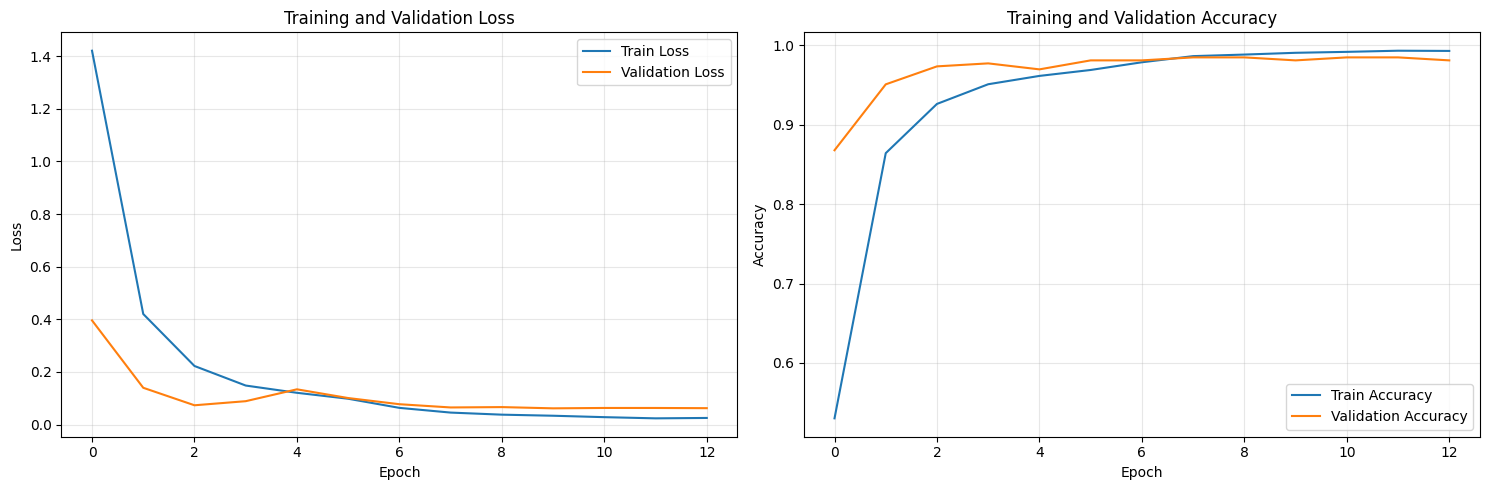

In [30]:
plot_training_history(history)

Testing: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


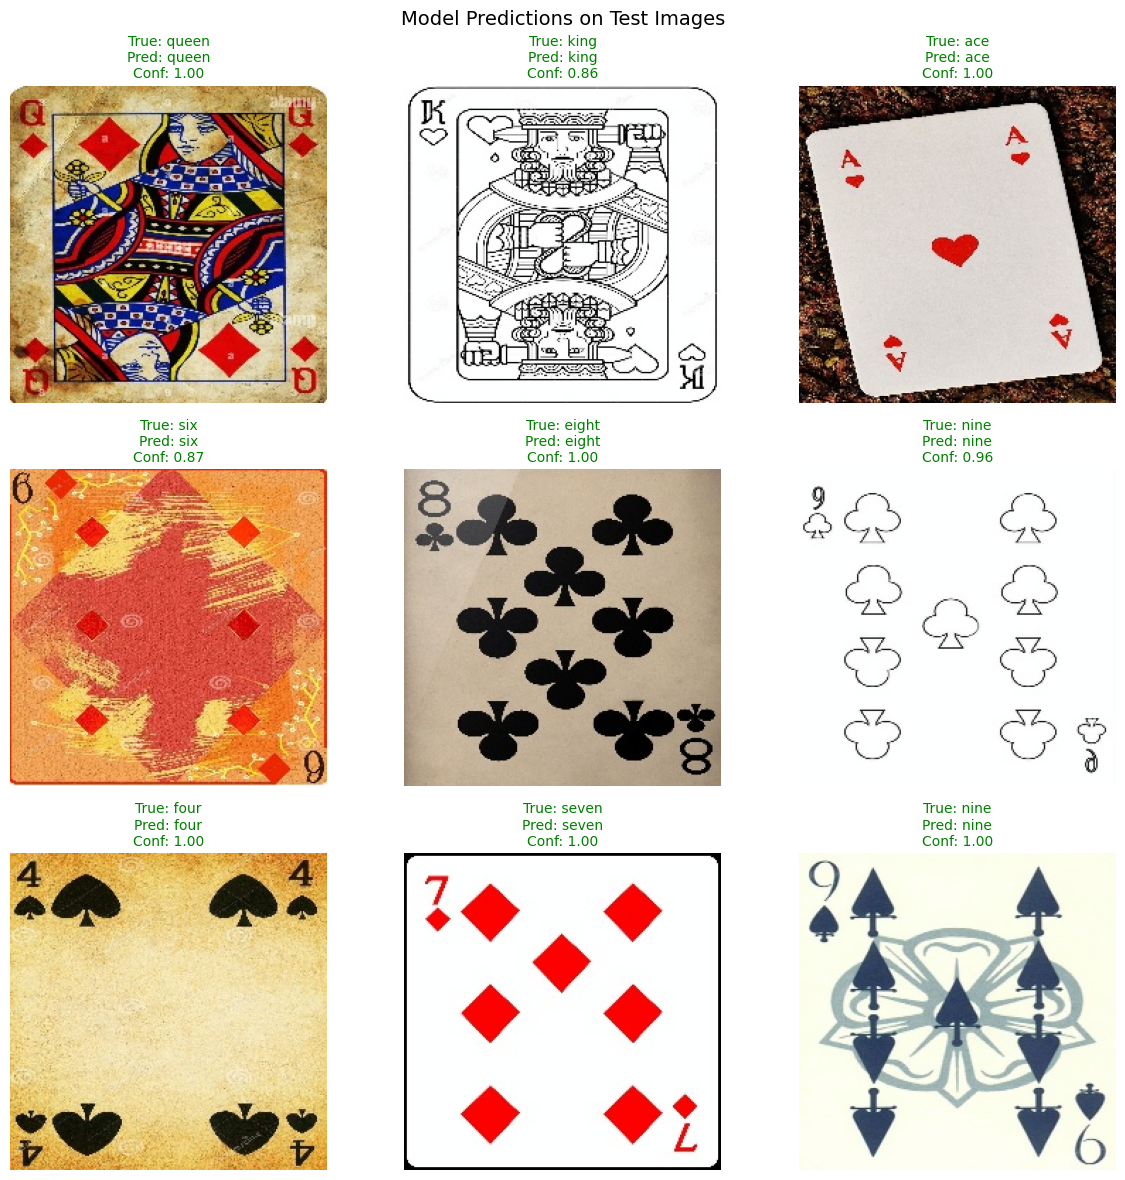

In [31]:
visualize_predictions(
    test_results['probabilities'], val_loader, class_names,
    num_images=9, save_path="predictions_val.png"
)

In [34]:
import torch.nn.functional as F
def predict_and_visualize(image_path, model, transform, class_names, device,
                          top_k=3, figsize=(12, 6)):


    try:
        original_image = Image.open(image_path).convert('RGB')
    except Exception as e:
        print(f"Ошибка загрузки изображения: {e}")
        return None

    image_tensor = transform(original_image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = F.softmax(outputs, dim=1)
        top_probs, top_indices = torch.topk(probabilities, k=top_k)

    top_probs = top_probs.cpu().numpy()[0]
    top_indices = top_indices.cpu().numpy()[0]
    top_classes = [class_names[idx] for idx in top_indices]

    all_probs = probabilities.cpu().numpy()[0]

    fig, axes = plt.subplots(1, 2, figsize=figsize)

    axes[0].imshow(original_image)
    axes[0].axis('off')

    predicted_class = top_classes[0]
    confidence = top_probs[0] * 100

    title = f'Predicted: {predicted_class}\nConfidence: {confidence:.1f}%'
    axes[0].set_title(title, fontsize=14, fontweight='bold', color='darkblue')
    y_pos = np.arange(len(top_classes))

    bars = axes[1].barh(y_pos, top_probs * 100, color='steelblue', alpha=0.7)
    axes[1].set_yticks(y_pos)
    axes[1].set_yticklabels(top_classes, fontsize=12)
    axes[1].set_xlabel('Probability (%)', fontsize=12)
    axes[1].set_title(f'Top-{top_k} Predictions', fontsize=14, fontweight='bold')
    axes[1].invert_yaxis()

    for i, (bar, prob) in enumerate(zip(bars, top_probs)):
        width = bar.get_width()
        axes[1].text(width + 1, bar.get_y() + bar.get_height()/2,
                    f'{prob*100:.1f}%', va='center', fontsize=11)


    axes[1].set_xlim([0, 105])
    axes[1].grid(True, axis='x', alpha=0.3)

    plt.tight_layout()
    plt.show()


    print("=" * 60)
    print(f"Image: {os.path.basename(image_path)}")
    print(f"Size: {original_image.size}")
    print("-" * 60)
    print("Top predictions:")
    for i, (class_name, prob) in enumerate(zip(top_classes, top_probs), 1):
        print(f"{i}. {class_name}: {prob*100:.2f}%")
    print("=" * 60)


    results = {
        'image': original_image,
        'top_classes': top_classes,
        'top_probabilities': top_probs,
        'all_probabilities': all_probs,
        'predicted_class': predicted_class,
        'confidence': confidence,
        'top_indices': top_indices
    }

    return results


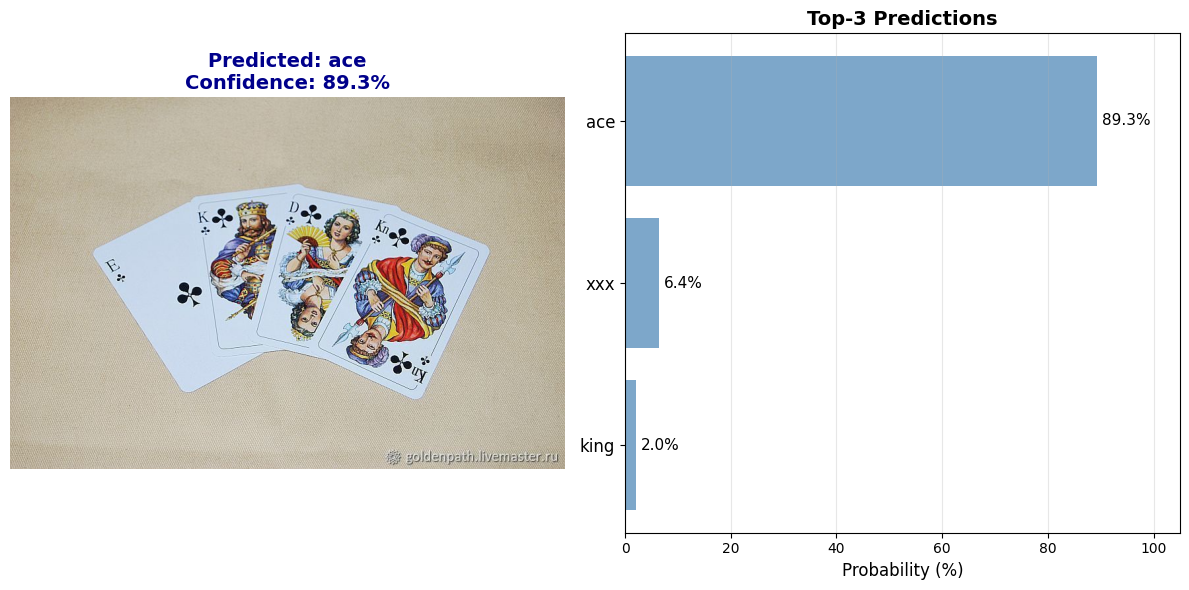

Image: 0.jpg
Size: (840, 562)
------------------------------------------------------------
Top predictions:
1. ace: 89.32%
2. xxx: 6.44%
3. king: 2.01%


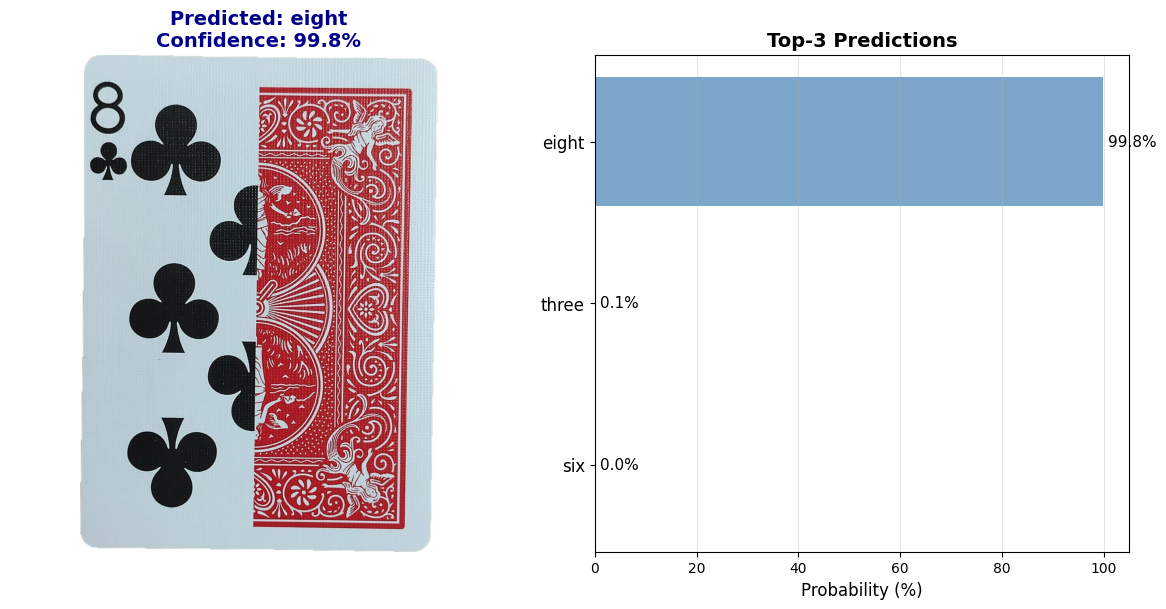

Image: 1.jpg
Size: (1200, 1200)
------------------------------------------------------------
Top predictions:
1. eight: 99.79%
2. three: 0.14%
3. six: 0.04%


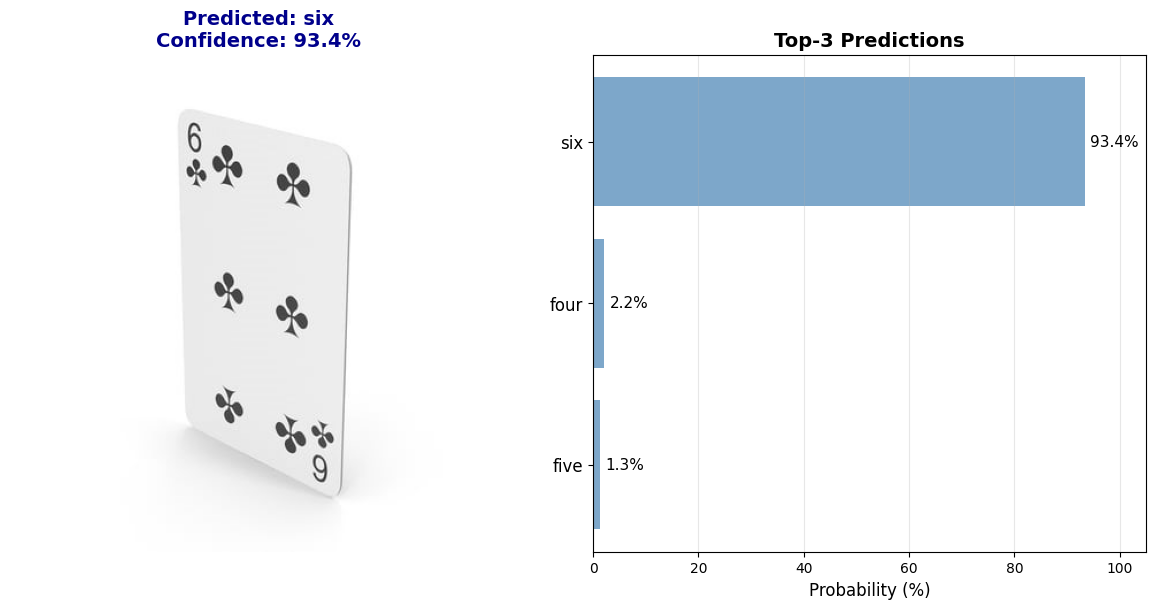

Image: 2.jpg
Size: (433, 433)
------------------------------------------------------------
Top predictions:
1. six: 93.44%
2. four: 2.16%
3. five: 1.35%


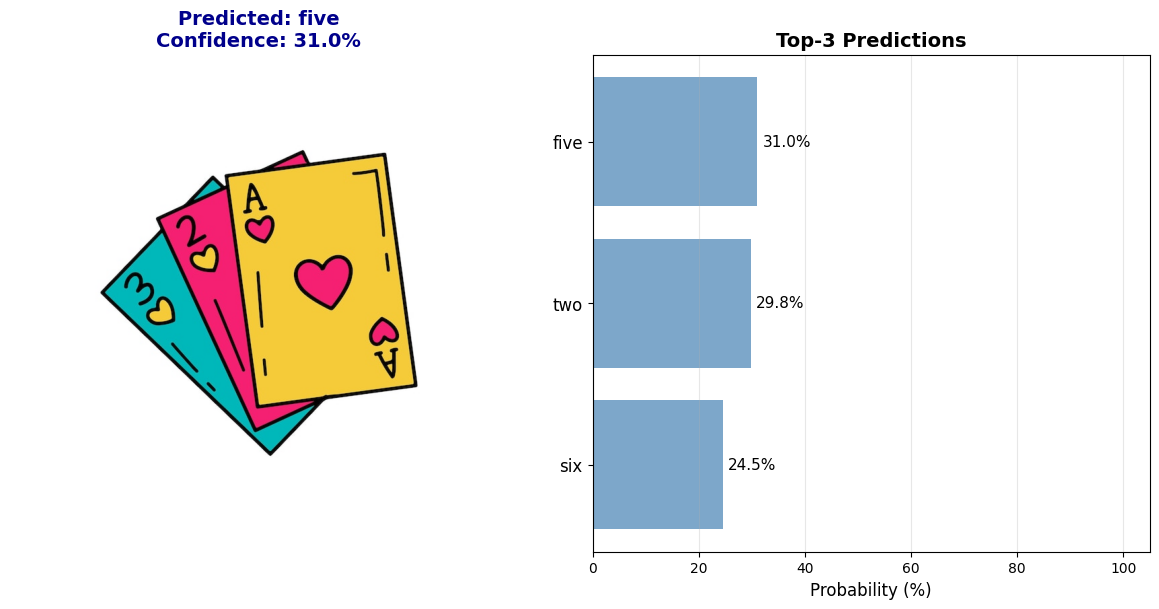

Image: 3.jpg
Size: (740, 740)
------------------------------------------------------------
Top predictions:
1. five: 30.99%
2. two: 29.78%
3. six: 24.49%


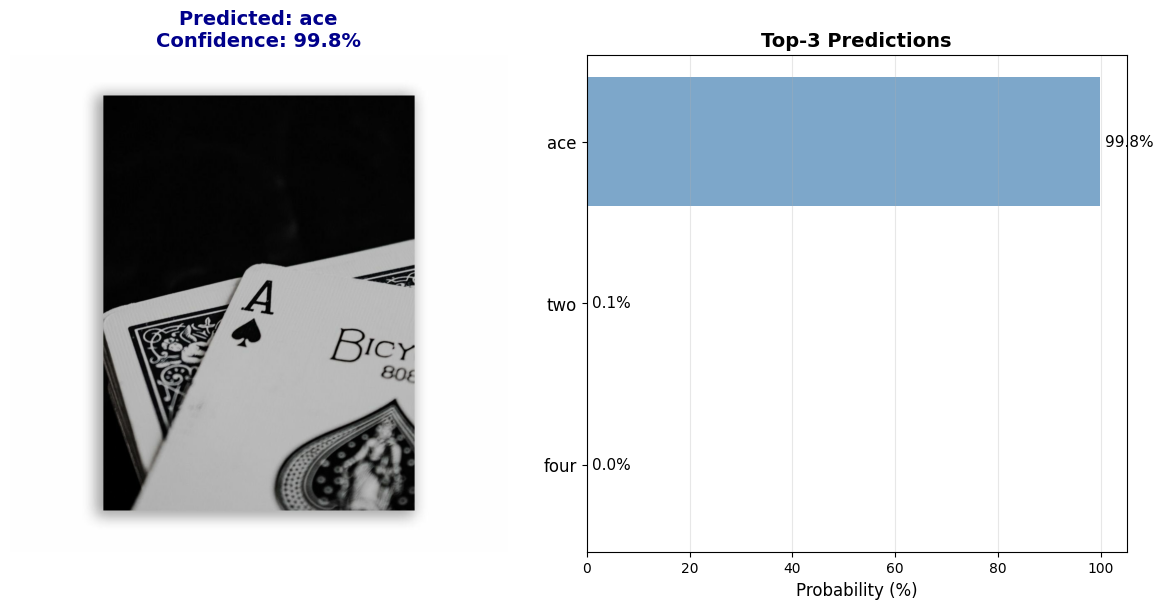

Image: 4.jpg
Size: (1200, 1200)
------------------------------------------------------------
Top predictions:
1. ace: 99.82%
2. two: 0.10%
3. four: 0.03%


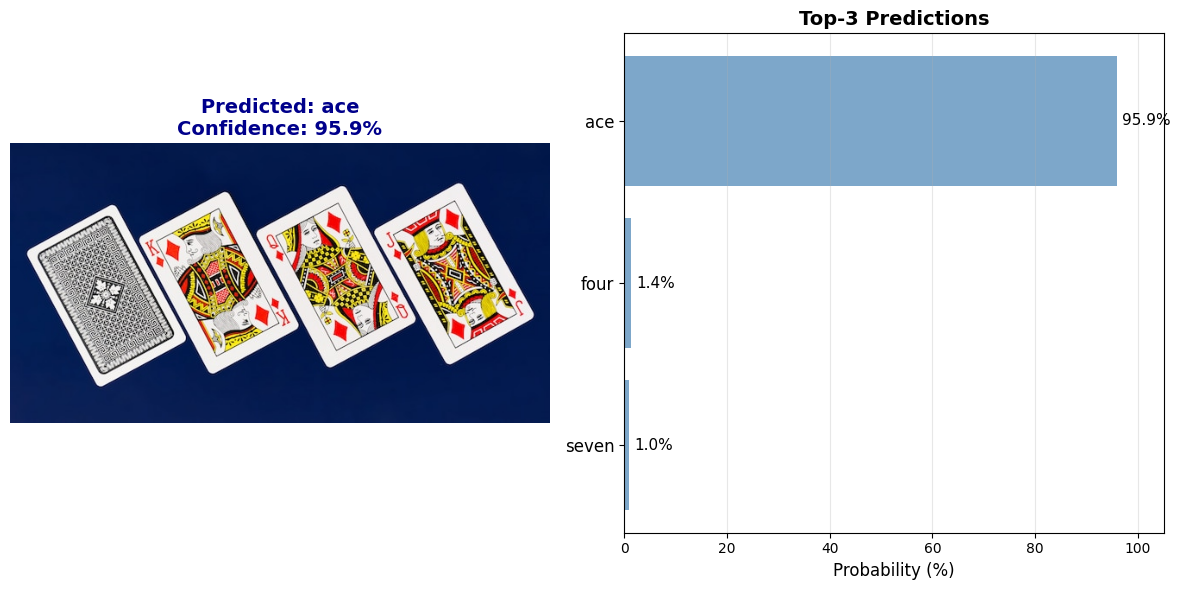

Image: 5.jpg
Size: (626, 325)
------------------------------------------------------------
Top predictions:
1. ace: 95.94%
2. four: 1.40%
3. seven: 0.95%


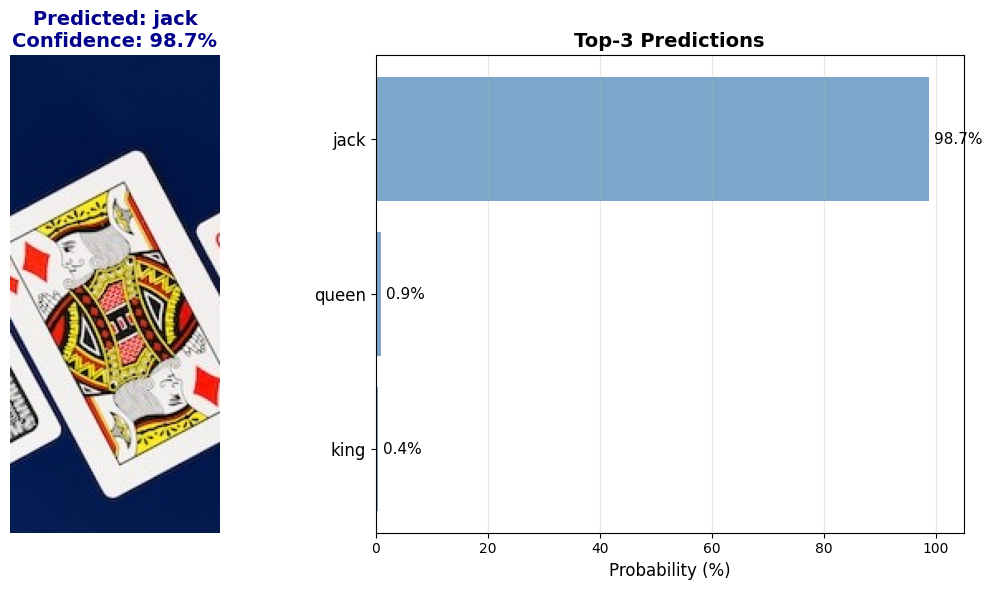

Image: 6.jpg
Size: (127, 289)
------------------------------------------------------------
Top predictions:
1. jack: 98.73%
2. queen: 0.85%
3. king: 0.36%


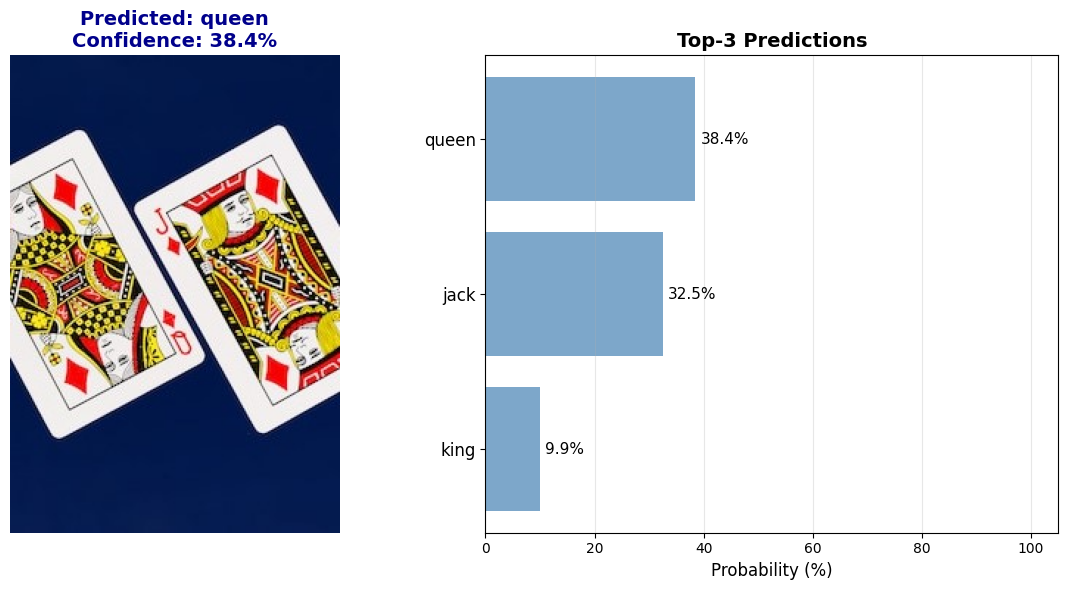

Image: 7.jpg
Size: (224, 325)
------------------------------------------------------------
Top predictions:
1. queen: 38.41%
2. jack: 32.51%
3. king: 9.92%


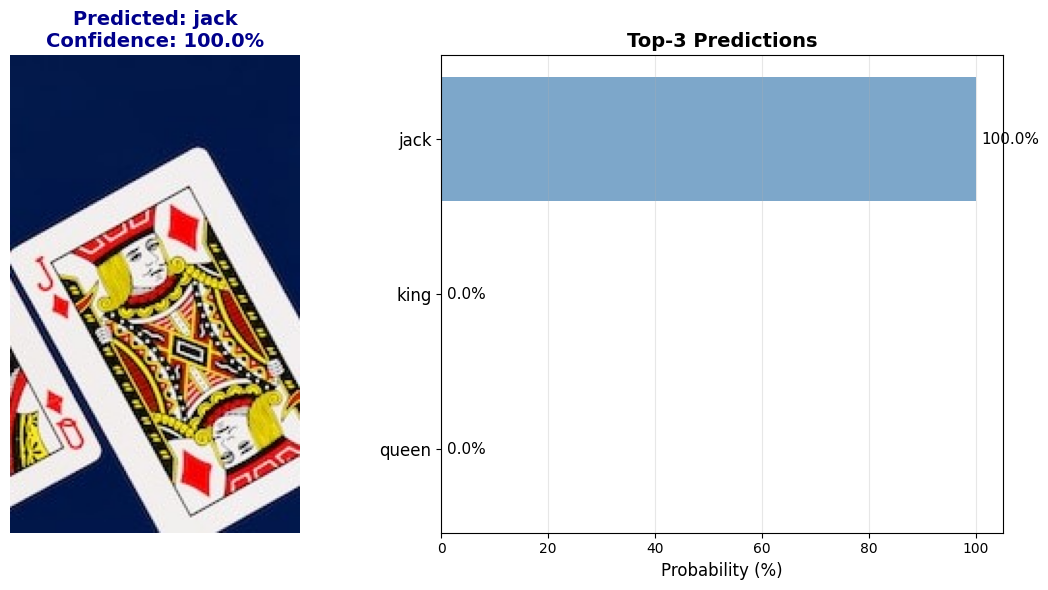

Image: 8.jpg
Size: (150, 247)
------------------------------------------------------------
Top predictions:
1. jack: 99.97%
2. king: 0.03%
3. queen: 0.00%


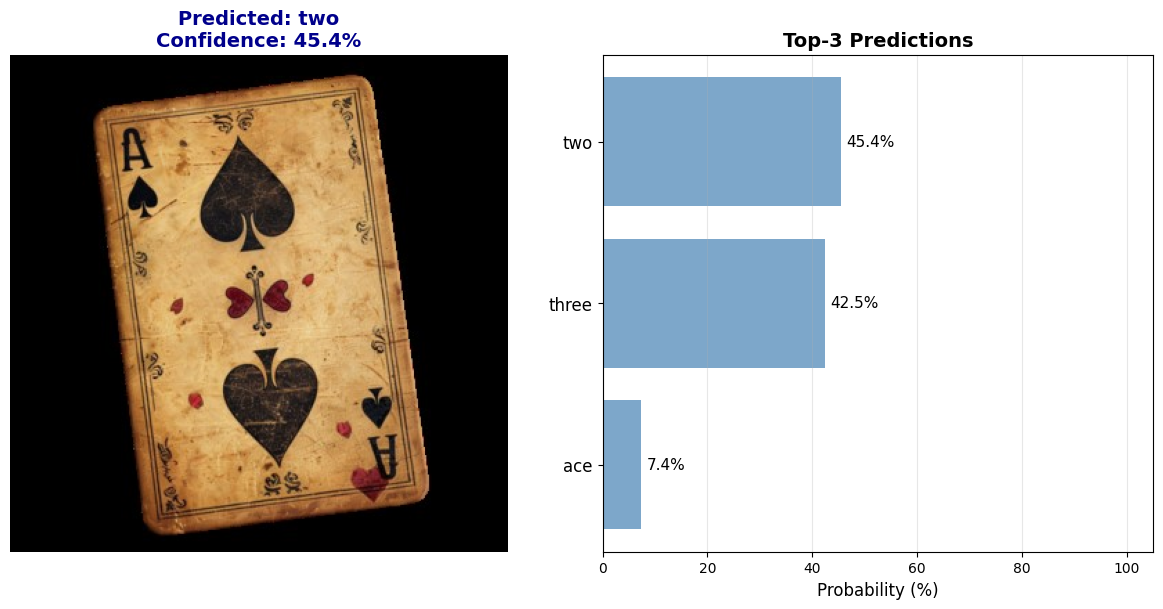

Image: 9.jpg
Size: (360, 360)
------------------------------------------------------------
Top predictions:
1. two: 45.39%
2. three: 42.51%
3. ace: 7.37%


In [35]:

for i in range(10):
  results = predict_and_visualize(
     image_path=f'/content/cards/{i}.jpg',
     model=model,
     transform=val_test_transform,
     class_names=class_names,
     device=device,
     top_k=3
 )